In [666]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline
plt.style.use('ggplot')


import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
sns.set(font_scale=1)
from sklearn.model_selection import GridSearchCV
score_calc = 'neg_mean_squared_error'
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# pandas settings

In [667]:
#pandas settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Import Data

In [600]:
train = pd.read_csv('/Users/rociobecerra/Desktop/Project-Tribore/RocioBecerra/train.csv')
test = pd.read_csv('/Users/rociobecerra/Desktop/Project-Tribore/RocioBecerra/test.csv')

# Preprocessing Train Data

In [668]:
#OLS to impute LotFrontage
def fill_mv_LotFrontage(df,r0):
    '''
    Fills in missing lot frontage values using regression where it makes sense
    and median value otherwise
    '''
    ols = linear_model.LinearRegression()
    nhoods = df.Neighborhood.unique()

    for nhood in nhoods:
        df_n = df[ df['Neighborhood'] == nhood ]
        mv_idx = (df['Neighborhood'] == nhood) & (df['LotFrontage'].isnull())
        
        # iwf there are mv in this neighborhood
        if np.sum(mv_idx) > 0:
            X = np.array(df_n.loc[ df_n['LotFrontage'].notnull(),['LotArea']]).reshape(-1,1)
            Y = np.array(df_n.loc[ df_n['LotFrontage'].notnull(), ['LotFrontage']])
            ols.fit(X,Y)
            R2 = ols.score(X,Y)
            #print(nhood, "R^2: %.2f" %R2, "beta_1: %.3f" %ols.coef_, "beta_0: %.3f" %ols.intercept_)
        
            # if neighborhood based regression on LotArea has decent R^2
            if R2 > r0:
                df.loc[ mv_idx , ['LotFrontage'] ] = ols.predict( np.array(df.loc[mv_idx, 'LotArea' ]).reshape(-1,1) )
                print("imputed with regression \n", df.loc[ mv_idx , ['LotFrontage'] ],"\n" )
            else:
                df.loc[ mv_idx , ['LotFrontage'] ] = np.median(X)
                print("imputed with neighborhood median \n",  df.loc[ mv_idx , ['LotFrontage'] ],"\n" )
    return df

In [602]:
train = fill_mv_LotFrontage(train, 0.5)

imputed with neighborhood median 
       LotFrontage
43         9359.5
64         9359.5
203        9359.5
214        9359.5
518        9359.5
539        9359.5
593        9359.5
610        9359.5
612        9359.5
690        9359.5
721        9359.5
811        9359.5
856        9359.5
879        9359.5
911        9359.5
928        9359.5
983        9359.5
1033       9359.5
1037       9359.5
1318       9359.5
1342       9359.5
1354       9359.5
1368       9359.5
1441       9359.5 

imputed with neighborhood median 
       LotFrontage
160       10768.0
672       10768.0
1164      10768.0
1253      10768.0 

imputed with neighborhood median 
       LotFrontage
113       10594.0
218       10594.0
529       10594.0
726       10594.0
1059      10594.0
1161      10594.0
1244      10594.0
1268      10594.0
1301      10594.0
1419      10594.0 

imputed with neighborhood median 
       LotFrontage
496       12011.0
541       12011.0
564       12011.0
1032      12011.0
1057      12011.0
1312    

In [669]:
def preprocessed(train):
    train = train.sort_index(axis=1) #alphabetically order 

    train['MSSubClass'] = train['MSSubClass'].astype(str) #MSSubClass: The building class CONVERT to String 
    train['MoSold'] = train['MoSold'].astype(str) #MoSold: Month Sold
    train["Electrical"] = train["Electrical"].fillna('SBrkr') #train["Electrical"] = train["Electrical"].fillna('SBrkr')
    train['MasVnrArea'] = train['MasVnrArea'].replace(np.nan, 0)
    train['GarageYrBlt'] = train['GarageYrBlt'].replace(np.nan, 0)
    
    #Replace categorical missing values with 'None'
    categorical = ['Alley','MasVnrType','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1', \
               'BsmtFinType2','FireplaceQu','GarageType','GarageFinish', \
               'GarageQual','GarageCond','PoolQC','Fence','MiscFeature']
    c_list = sorted(categorical)
    for feature in c_list:
        train[feature]=train[feature].replace(np.nan, 'None')
        
    #dummy code
    #train = pd.get_dummies(train, drop_first=True)
    
    return(train)

In [670]:
train_1 = preprocessed(train)

In [671]:
train_1.head()

1stFlrSF  2ndFlrSF  3SsnPorch Alley  BedroomAbvGr BldgType BsmtCond BsmtExposure  BsmtFinSF1  BsmtFinSF2 BsmtFinType1 BsmtFinType2  BsmtFullBath  BsmtHalfBath BsmtQual  BsmtUnfSF CentralAir Condition1 Condition2 Electrical  EnclosedPorch ExterCond ExterQual Exterior1st Exterior2nd Fence FireplaceQu  Fireplaces Foundation  FullBath Functional  GarageArea  GarageCars GarageCond GarageFinish GarageQual GarageType  GarageYrBlt  GrLivArea  HalfBath Heating HeatingQC HouseStyle  Id  KitchenAbvGr KitchenQual LandContour LandSlope  LotArea LotConfig  LotFrontage LotShape  LowQualFinSF MSSubClass MSZoning  MasVnrArea MasVnrType MiscFeature  MiscVal MoSold Neighborhood  OpenPorchSF  OverallCond  OverallQual PavedDrive  PoolArea PoolQC RoofMatl RoofStyle SaleCondition  SalePrice SaleType  ScreenPorch Street  TotRmsAbvGrd  TotalBsmtSF Utilities  WoodDeckSF  YearBuilt  YearRemodAdd  YrSold
0       856       854          0  None             3     1Fam       TA           No         706           0          GLQ          Unf             1             0       Gd        150          Y       Norm       Norm      SBrkr              0        TA        Gd     VinylSd     VinylSd  None        None           0      PConc         2        Typ         548           2         TA          RFn         TA     Attchd       2003.0       1710         1    GasA        Ex     2Story   1             1          Gd         Lvl       Gtl     8450    Inside         65.0      Reg             0         60       RL       196.0    BrkFace        None        0      2      CollgCr           61            5            7          Y         0   None  CompShg     Gable        Normal     208500       WD            0   Pave             8          856    AllPub           0       2003          2003    2008
1      1262         0          0  None             3     1Fam       TA           Gd         978           0          ALQ          Unf             0             1       Gd        284          Y      Feedr       Norm      SBrkr              0        TA        TA     MetalSd     MetalSd  None          TA           1     CBlock         2        Typ         460           2         TA          RFn         TA     Attchd       1976.0       1262         0    GasA        Ex     1Story   2             1          TA         Lvl       Gtl     9600       FR2         80.0      Reg             0         20       RL         0.0       None        None        0      5      Veenker            0            8            6          Y         0   None  CompShg     Gable        Normal     181500       WD            0   Pave             6         1262    AllPub         298       1976          1976    2007
2       920       866          0  None             3     1Fam       TA           Mn         486           0          GLQ          Unf             1             0       Gd        434          Y       Norm       Norm      SBrkr              0        TA        Gd     VinylSd     VinylSd  None          TA           1      PConc         2        Typ         608           2         TA          RFn         TA     Attchd       2001.0       1786         1    GasA        Ex     2Story   3             1          Gd         Lvl       Gtl    11250    Inside         68.0      IR1             0         60       RL       162.0    BrkFace        None        0      9      CollgCr           42            5            7          Y         0   None  CompShg     Gable        Normal     223500       WD            0   Pave             6          920    AllPub           0       2001          2002    2008
3       961       756          0  None             3     1Fam       Gd           No         216           0          ALQ          Unf             1             0       TA        540          Y       Norm       Norm      SBrkr            272        TA        TA     Wd Sdng     Wd Shng  None          Gd           1     BrkTil         1        Typ         642           3         TA          Unf         TA     Detchd       1998.0  

In [672]:
train_1['Age'] = train_1['YrSold'] - train_1['YearBuilt']
train_1['Re_Age'] = train_1['YrSold'] - train_1['YearRemodAdd']
train_1['LogSalePrice'] = np.log(train_1['SalePrice'])

In [674]:
mtrain_2 = train_1[["1stFlrSF",'SalePrice',"LogSalePrice",'BsmtExposure','BsmtFinType1','CentralAir','GarageType','HeatingQC','BsmtQual',
'ExterQual','FireplaceQu','Foundation','GarageFinish','KitchenQual','MasVnrType',
 'Neighborhood',"OverallQual","GrLivArea","GarageCars","FullBath","MasVnrArea",
 "Fireplaces","BsmtFinSF1","LotFrontage","WoodDeckSF","OpenPorchSF","Re_Age",'Age',"LotArea","HalfBath"]]

In [675]:
mtrain_2 = pd.get_dummies(mtrain_2, drop_first=True)

In [676]:
mtrain_3 = mtrain_2.copy()
mtrain_3

1stFlrSF  SalePrice  LogSalePrice  OverallQual  GrLivArea  GarageCars  FullBath  MasVnrArea  Fireplaces  BsmtFinSF1   LotFrontage  WoodDeckSF  OpenPorchSF  Re_Age  Age  LotArea  HalfBath  BsmtExposure_Gd  BsmtExposure_Mn  BsmtExposure_No  BsmtExposure_None  BsmtFinType1_BLQ  BsmtFinType1_GLQ  BsmtFinType1_LwQ  BsmtFinType1_None  BsmtFinType1_Rec  BsmtFinType1_Unf  CentralAir_Y  GarageType_Attchd  GarageType_Basment  GarageType_BuiltIn  GarageType_CarPort  GarageType_Detchd  GarageType_None  HeatingQC_Fa  HeatingQC_Gd  HeatingQC_Po  HeatingQC_TA  BsmtQual_Fa  BsmtQual_Gd  BsmtQual_None  BsmtQual_TA  ExterQual_Fa  ExterQual_Gd  ExterQual_TA  FireplaceQu_Fa  FireplaceQu_Gd  FireplaceQu_None  FireplaceQu_Po  FireplaceQu_TA  Foundation_CBlock  Foundation_PConc  Foundation_Slab  Foundation_Stone  Foundation_Wood  GarageFinish_None  GarageFinish_RFn  GarageFinish_Unf  KitchenQual_Fa  KitchenQual_Gd  KitchenQual_TA  MasVnrType_BrkFace  MasVnrType_None  MasVnrType_Stone  \
0          856     208500     12.247694            7       1710           2         2       196.0           0         706     65.000000           0           61       5    5     8450         1                0                0                1                  0                 0                 1                 0                  0                 0                 0             1                  1                   0                   0                   0                  0                0             0             0             0             0            0            1              0            0             0             1             0               0               0                 1               0               0                  0                 1                0                 0                0                  0                 1                 0               0               1               0                   1                0                 0   
1         1262     181500     12.109011            6       1262           2         2         0.0           1         978     80.000000         298            0      31   31     9600         0                1                0                0                  0                 0                 0                 0                  0                 0                 0             1                  1                   0                   0                   0                  0                0             0             0             0             0            0            1              0            0             0             0             1               0               0                 0               0               1                  1                 0                0                 0                0                  0                 1                 0               0               0               1                   0                1                 0   
2          920     223500     12.317167            7       1786           2         2       162.0           1         486     68.000000           0           42       6    7    11250         1                0                1                0                  0                 0                 1                 0                  0                 0                 0             1                  1                   0                   0                   0                  0                0             0             0             0             0            0            1              0            0             0             1             0               0               0                 0               0               1                  0                 1                0                 0                0                  0                 1                 0               0               1               0                   1                0                 0   
3          961     140000     11.849398            7       1717   

# Removing Outliers from GrLivArea, LotFrontage, MasVnrArea, 1stFlrSF, SalePrice

In [679]:
#outliers 
upperlimit = np.percentile(mtrain_3.GrLivArea.values, 99.5)
mtrain_3['GrLivArea'].loc[mtrain_3['GrLivArea']>upperlimit] = upperlimit

In [680]:
#outliers 
upperlimit = np.percentile(mtrain_3.LotFrontage.values, 99.5)
mtrain_3['LotFrontage'].loc[mtrain_3['LotFrontage']>upperlimit] = upperlimit

In [681]:
#outliers 
upperlimit = np.percentile(mtrain_3.MasVnrArea.values, 99.5)
mtrain_3['MasVnrArea'].loc[mtrain_3['MasVnrArea']>upperlimit] = upperlimit

In [682]:
#outliers 
upperlimit = np.percentile(mtrain_3['1stFlrSF'].values, 99.5)
mtrain_3['1stFlrSF'].loc[mtrain_3['1stFlrSF']>upperlimit] = upperlimit

In [683]:
#outliers 
upperlimit = np.percentile(mtrain_3.SalePrice.values, 99.5)
mtrain_3['SalePrice'].loc[mtrain_3['SalePrice']>upperlimit] = upperlimit

# Log Sale Price

In [685]:
mtrain_3['LogSalePrice2'] = np.log(mtrain_3['SalePrice'])

# Dropping some variables

In [686]:
mtrain_3 = mtrain_3.drop(['LogSalePrice', 'SalePrice'], axis=1)

In [687]:
mtrain_3 = mtrain_3.drop(["Re_Age"], axis=1)

# Sorting Columns in Train Data

In [689]:
mtrain_3 = mtrain_3.sort_index(axis=1)

In [690]:
mtrain_3.head()

1stFlrSF  Age  BsmtExposure_Gd  BsmtExposure_Mn  BsmtExposure_No  BsmtExposure_None  BsmtFinSF1  BsmtFinType1_BLQ  BsmtFinType1_GLQ  BsmtFinType1_LwQ  BsmtFinType1_None  BsmtFinType1_Rec  BsmtFinType1_Unf  BsmtQual_Fa  BsmtQual_Gd  BsmtQual_None  BsmtQual_TA  CentralAir_Y  ExterQual_Fa  ExterQual_Gd  ExterQual_TA  FireplaceQu_Fa  FireplaceQu_Gd  FireplaceQu_None  FireplaceQu_Po  FireplaceQu_TA  Fireplaces  Foundation_CBlock  Foundation_PConc  Foundation_Slab  Foundation_Stone  Foundation_Wood  FullBath  GarageCars  GarageFinish_None  GarageFinish_RFn  GarageFinish_Unf  GarageType_Attchd  GarageType_Basment  GarageType_BuiltIn  GarageType_CarPort  GarageType_Detchd  GarageType_None  GrLivArea  HalfBath  HeatingQC_Fa  HeatingQC_Gd  HeatingQC_Po  HeatingQC_TA  KitchenQual_Fa  KitchenQual_Gd  KitchenQual_TA  LogSalePrice2  LotArea  LotFrontage  MasVnrArea  MasVnrType_BrkFace  MasVnrType_None  MasVnrType_Stone  Neighborhood_Blueste  Neighborhood_BrDale  Neighborhood_BrkSide  \
0     856.0    5                0                0                1                  0         706                 0                 1                 0                  0                 0                 0            0            1              0            0             1             0             1             0               0               0                 1               0               0           0                  0                 1                0                 0                0         2           2                  0                 1                 0                  1                   0                   0                   0                  0                0     1710.0         1             0             0             0             0               0               1               0      12.247694     8450         65.0       196.0                   1                0                 0                     0                    0                     0   
1    1262.0   31                1                0                0                  0         978                 0                 0                 0                  0                 0                 0            0            1              0            0             1             0             0             1               0               0                 0               0               1           1                  1                 0                0                 0                0         2           2                  0                 1                 0                  1                   0                   0                   0                  0                0     1262.0         0             0             0             0             0               0               0               1      12.109011     9600         80.0         0.0                   0                1                 0                     0                    0                     0   
2     920.0    7                0                1                0                  0         486                 0                 1                 0                  0                 0                 0            0            1              0            0             1             0             1             0               0               0                 0               0               1           1                  0                 1                0                 0                0         2           2                  0                 1                 0                  1                   0                   0                   0                  0                0     1786.0         1             0             0             0             0               0               1               0      12.317167    11250         68.0       162.0                   1                0                 0                     0                    0                     0   
3     961.0   91                0          

# Preprocessing Test Data

In [691]:
test = fill_mv_LotFrontage(test, 0.5)

In [692]:
test = preprocessed(test)

In [693]:
test['Age'] = test['YrSold'] - test['YearBuilt']
#test['Re_Age'] = test['YrSold'] - test['YearRemodAdd']

# Check missing values 

In [696]:
check_columns=test.columns[test.isnull().any()]
test[check_columns].isnull().sum()

BsmtFinSF1      1
BsmtFinSF2      1
BsmtFullBath    2
BsmtHalfBath    2
BsmtUnfSF       1
Exterior1st     1
Exterior2nd     1
Functional      2
GarageArea      1
GarageCars      1
KitchenQual     1
MSZoning        4
SaleType        1
TotalBsmtSF     1
Utilities       2
dtype: int64

In [697]:
test_2 = test[["1stFlrSF",'BsmtExposure','BsmtFinType1','CentralAir','GarageType','HeatingQC','BsmtQual',
'ExterQual','FireplaceQu','Foundation','GarageFinish','KitchenQual','MasVnrType',
 'Neighborhood',"OverallQual","GrLivArea","GarageCars","FullBath","MasVnrArea",
 "Fireplaces","BsmtFinSF1","LotFrontage","WoodDeckSF","OpenPorchSF",'Age',"LotArea","HalfBath"]]

In [698]:
#Check missing values 
check_columns=test_2.columns[test_2.isnull().any()]
test_2[check_columns].isnull().sum()

KitchenQual    1
GarageCars     1
BsmtFinSF1     1
dtype: int64

In [699]:
test_2['KitchenQual'] = test_2['KitchenQual'].replace(np.nan, 'TA')
test_2['GarageCars'] = test_2['GarageCars'].replace(np.nan, 0)
test_2['BsmtFinSF1'] = test_2['BsmtFinSF1'].replace(np.nan, 0)

/Users/rociobecerra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/rociobecerra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/rociobecerra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [700]:
test_2 = pd.get_dummies(test_2, drop_first=True)

# Sort Columns for Test Data

In [701]:
test_2 = test_2.sort_index(axis=1)

In [702]:
test_2.head()

1stFlrSF  Age  BsmtExposure_Gd  BsmtExposure_Mn  BsmtExposure_No  BsmtExposure_None  BsmtFinSF1  BsmtFinType1_BLQ  BsmtFinType1_GLQ  BsmtFinType1_LwQ  BsmtFinType1_None  BsmtFinType1_Rec  BsmtFinType1_Unf  BsmtQual_Fa  BsmtQual_Gd  BsmtQual_None  BsmtQual_TA  CentralAir_Y  ExterQual_Fa  ExterQual_Gd  ExterQual_TA  FireplaceQu_Fa  FireplaceQu_Gd  FireplaceQu_None  FireplaceQu_Po  FireplaceQu_TA  Fireplaces  Foundation_CBlock  Foundation_PConc  Foundation_Slab  Foundation_Stone  Foundation_Wood  FullBath  GarageCars  GarageFinish_None  GarageFinish_RFn  GarageFinish_Unf  GarageType_Attchd  GarageType_Basment  GarageType_BuiltIn  GarageType_CarPort  GarageType_Detchd  GarageType_None  GrLivArea  HalfBath  HeatingQC_Fa  HeatingQC_Gd  HeatingQC_Po  HeatingQC_TA  KitchenQual_Fa  KitchenQual_Gd  KitchenQual_TA  LotArea  LotFrontage  MasVnrArea  MasVnrType_BrkFace  MasVnrType_None  MasVnrType_Stone  Neighborhood_Blueste  Neighborhood_BrDale  Neighborhood_BrkSide  Neighborhood_ClearCr  \
0       896   49                0                0                1                  0       468.0                 0                 0                 0                  0                 1                 0            0            0              0            1             1             0             0             1               0               0                 1               0               0           0                  1                 0                0                 0                0         1         1.0                  0                 0                 1                  1                   0                   0                   0                  0                0        896         0             0             0             0             1               0               0               1    11622         80.0         0.0                   0                1                 0                     0                    0                     0                     0   
1      1329   52                0                0                1                  0       923.0                 0                 0                 0                  0                 0                 0            0            0              0            1             1             0             0             1               0               0                 1               0               0           0                  1                 0                0                 0                0         1         1.0                  0                 0                 1                  1                   0                   0                   0                  0                0       1329         1             0             0             0             1               0               1               0    14267         81.0       108.0                   1                0                 0                     0                    0                     0                     0   
2       928   13                0                0                1                  0       791.0                 0                 1                 0                  0                 0                 0            0            1              0            0             1             0             0             1               0               0                 0               0               1           1                  0                 1                0                 0                0         2         2.0                  0                 0                 0                  1                   0                   0                   0                  0                0       1629         1             0             1             0             0               0               0               1    13830         74.0         0.0                   0                1                 0                     0                    0                     0                     0   
3       926   1

# Checking if there are missing columns in TRAIN And TEST dataframe by matching columns

In [703]:
list_test =list(test_2.columns)
list_train = list(mtrain_3.columns)

In [704]:
def returnNotMatches(a, b):
    return [[x for x in a if x not in b], [x for x in b if x not in a]]

In [705]:
returnNotMatches(list_train, list_test)

[['LogSalePrice2'], []]

In [707]:
mtrain_3.shape

(1460, 86)

In [709]:
test_2.shape

(1459, 85)

# Linear Regression 

In [710]:
n_cv = 5

def cv_best_score(grid):  
    best_score = np.sqrt(-grid.best_score_)
    print(best_score)    
    #print(grid.best_params_)
    #print(grid.best_estimator_)
    return best_score

In [711]:
housefeatures = mtrain_3.loc[:, mtrain_3.columns != 'LogSalePrice2']
price = mtrain_3['LogSalePrice2']
price = pd.DataFrame(price)


In [712]:
lm = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_lm = GridSearchCV(lm, parameters, cv = n_cv, verbose = 1 , scoring = score_calc)
grid_lm.fit(housefeatures,price)
sc_lm = cv_best_score(grid_lm)
pred_lm_all = grid_lm.predict(test_2)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.14057940169331398


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.5s finished


In [713]:
submit_lm = pd.DataFrame()
submit_lm['Id'] = test['Id']
submit_lm['SalePrice'] = pred_lm_all
submit_lm['SalePrice'] = np.exp(submit_lm['SalePrice'])
submit_lm.to_csv('submit_lm.csv',index=False)

# Ridge 

In [714]:
ridge = Ridge()
parameters = {'alpha':[0.001,0.005,0.01,0.1,0.5,1], 'normalize':[True,False], 'tol':[1e-06,5e-06,1e-05,5e-05]}
grid_ridge = GridSearchCV(ridge, parameters, cv = n_cv, verbose = 1, scoring = score_calc)
grid_ridge.fit(housefeatures,price)
sc_ridge = cv_best_score(grid_ridge)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.14025108295805663


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    2.6s finished


In [715]:
pred_ridge_all = grid_ridge.predict(test_2)
pred_ridge_all

array([[11.66350537],
       [11.98358905],
       [12.08347118],
       ...,
       [11.94367495],
       [11.63302765],
       [12.28792737]])

In [716]:
submit_ridge = pd.DataFrame()
submit_ridge['Id'] = test['Id']
submit_ridge['SalePrice'] = pred_ridge_all
submit_ridge['SalePrice'] = np.exp(submit_ridge['SalePrice'])
submit_ridge.to_csv('submit_ridge.csv',index = False)

# LASSO

In [717]:
lasso = Lasso()
parameters = {'alpha':[1e-03,0.01,0.1,0.5,0.8,1], 'normalize':[True,False], 'tol':[1e-06,1e-05,5e-05,1e-04,5e-04,1e-03]}
grid_lasso = GridSearchCV(lasso, parameters, cv = n_cv, verbose = 1, scoring = score_calc)
grid_lasso.fit(housefeatures,price)
sc_lasso = cv_best_score(grid_lasso)
pred_lasso_all = grid_lasso.predict(test_2)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.14488274799768866


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    3.2s finished


In [718]:
submit_lasso = pd.DataFrame()
submit_lasso['Id'] = test['Id']
submit_lasso['SalePrice'] = pred_lasso_all
submit_lasso['SalePrice'] = np.exp(submit_lasso['SalePrice'])
submit_lasso.to_csv('submit_lasso.csv',index=False)

# ElasticNet

In [719]:
enet = ElasticNet()
parameters = {'alpha' :[0.1,1.0,10], 'max_iter' :[1000000], 'l1_ratio':[0.04,0.05], 
              'fit_intercept' : [False,True], 'normalize':[True,False], 'tol':[1e-02,1e-03,1e-04]}
grid_enet = GridSearchCV(enet, parameters, cv = n_cv, verbose = 1, scoring = score_calc)
grid_enet.fit(housefeatures,price)
sc_enet = cv_best_score(grid_enet)
pred_enet = grid_enet.predict(test_2)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.1576215376838788


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    6.1s finished


In [720]:
submit_enet = pd.DataFrame()
submit_enet['Id'] = test['Id']
submit_enet['SalePrice'] = pred_enet
submit_enet['SalePrice'] = np.exp(submit_enet['SalePrice'])
submit_enet.to_csv('submit_enet.csv',index = False)

# Kaggle RMSE Scores 

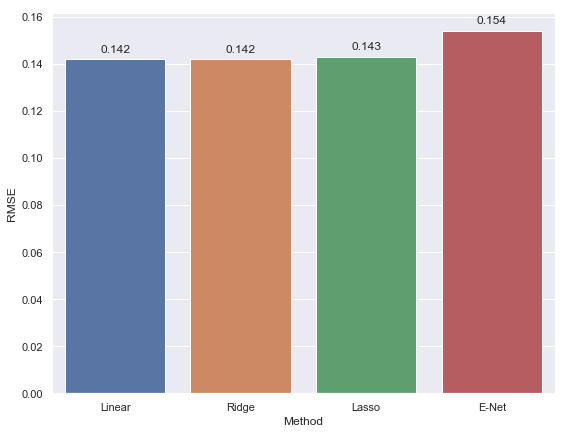

In [726]:
#make dataframe
d = {'Method': ['Linear', 'Ridge', 'Lasso', 'E-Net'], 'RMSE': [0.142,0.142,0.143,0.154]}
rmse = pd.DataFrame(d)
#plot graph
fig, ax = plt.subplots()
fig.set_size_inches(9,7)
sns.set(style="darkgrid")
ax = sns.barplot(x="Method", y="RMSE", data=rmse)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')